# Parallel NMDA processing

This notebook contains code for Fig. 5 of [Harkin, Shen _et al_. (2021)](https://doi.org/10.1101/2021.03.25.437091).

In [1]:
from typing import Callable

import numpy as np
from ezephys import stimtools as st
import matplotlib.pyplot as plt
from scipy.signal import lfilter

In [2]:
# experiment wide parameters
dt = 0.1

In [3]:
def DesignExponentialFilter(tau_ms, filter_length_ms):
  t = np.arange(0, filter_length_ms, dt)
  IRF_filter = np.exp(-t / tau_ms)
  IRF_filter = IRF_filter/sum(IRF_filter)
  IRF_filter[0] = 0
  return IRF_filter, t

def get_sigmoid(loc: float, sensitivity: float, gain: float) -> Callable[[np.ndarray], np.ndarray]:
    def sigmoid(x):
        return gain / (1 + np.exp(-(x - loc) / sensitivity))
    return sigmoid

def get_filter(kernel: np.ndarray) -> Callable[[np.ndarray], np.ndarray]:
  """Get a function that convolves the kernel with an input."""
  return lambda input_: lfilter(kernel, 1, input_, axis=-1, zi=None)

def get_linear_nonlinear_model(
  membrane_kernel: np.ndarray, nonlinear_kernel: np.ndarray) -> Callable[[np.ndarray], np.ndarray]:
  membrane_filter = get_filter(membrane_kernel)
  sodium_filter = get_filter(nonlinear_kernel)

  def linear_nonlinear_model(dendritic_input: np.ndarray, loc: float, sensit: float, gain: float) -> [np.ndarray, np.ndarray]:
    assert np.ndim(dendritic_input) == 1
    sigmoid = get_sigmoid(loc, sensit, gain)

    return [sigmoid(sodium_filter(dendritic_input)) + membrane_filter(dendritic_input), membrane_filter(dendritic_input)]
    
  return linear_nonlinear_model

In [4]:
def delayed_pulse(delay_ms: float, peak_amplitude: float, total_duration: float = 600.) -> st.ConvolvedStimulus:
    """Create ConvolvedStimulus containing a synaptic pulse with a delayed start."""
    synaptic_kernel = st.BiexponentialSynapticKernel(peak_amplitude, 0.1, 5, duration=25., dt=dt)

    pulse_time = np.zeros(int(total_duration / dt - 0.5))
    pulse_time[int(delay_ms / dt - 0.5)] = 1.
    pulse = st.ConvolvedStimulus(0, synaptic_kernel)
    pulse.generate(pulse_time, dt)
    return pulse, pulse_time

In [5]:
# na kernel
na_membrane_kernel, _ = DesignExponentialFilter(
    tau_ms=5, filter_length_ms=100)
na_nl_kernel, _ = DesignExponentialFilter(tau_ms=5, filter_length_ms=100)

na_kernel = get_linear_nonlinear_model(na_membrane_kernel, na_nl_kernel)

# ca kernel
ca_membrane_kernel, _ = DesignExponentialFilter(
    tau_ms=40, filter_length_ms=100)
ca_nl_kernel, _ = DesignExponentialFilter(tau_ms=40, filter_length_ms=200)

ca_kernel = get_linear_nonlinear_model(ca_membrane_kernel, ca_nl_kernel)

# nmda kernel
nmda_membrane_kernel, _ = DesignExponentialFilter(
    tau_ms=80, filter_length_ms=200)
nmda_nl_kernel, _ = DesignExponentialFilter(tau_ms=80, filter_length_ms=200)

nmda_kernel = get_linear_nonlinear_model(nmda_membrane_kernel, nmda_nl_kernel)

In [6]:
# computes max voltage of output trace as a function of input amplitude; control treatment and TTX+Cadmium treatment; TTX+Cadmium treatment simulated by setting sigmoid to 0 for Ca and Na
def compute_blocker_graph(na_loc, na_sensit, na_gain, ca_loc, ca_sensit, ca_gain, nmda_loc, nmda_sensit, nmda_gain):
    # create input intensities to evaluate
    min_intensity = 0
    max_intensity = 15

    intensities = np.arange(min_intensity, max_intensity, 0.4)
    peaks_control = np.zeros(len(intensities))
    peaks_blocked = np.zeros(len(intensities))

    # calculate peak amplitudes for non blocked Ca and Na channels
    for e, intensity in enumerate(intensities):
        input_epsp, _ = delayed_pulse(
            delay_ms=20, peak_amplitude=intensity)
        input_epsp = input_epsp.command.flatten()
        y_ca, _= ca_kernel(input_epsp, ca_loc, ca_sensit, ca_gain)
        y_na, _= na_kernel(input_epsp, na_loc, na_sensit, na_gain)
        y_nmda_sum, _ = nmda_kernel(
            y_ca+y_na, nmda_loc, nmda_sensit, nmda_gain)
        peak = np.max(y_nmda_sum)
        peaks_control[e] = peak


        # calculate peak amplitudes for blocked Ca and Na channels (set sigmoid gain to 0)
        for e, intensity in enumerate(intensities):
            input_epsp, _ = delayed_pulse(
                delay_ms=20, peak_amplitude=intensity)
            input_epsp = input_epsp.command.flatten()
            y_ca, _= ca_kernel(input_epsp, ca_loc, ca_sensit, 0)
            y_na, _= na_kernel(input_epsp, na_loc, na_sensit, 0)
            y_nmda_sum, _ = nmda_kernel(
                y_ca+y_na, nmda_loc, nmda_sensit, nmda_gain)
            peak = np.max(y_nmda_sum)
            peaks_blocked[e] = peak

    return [intensities, peaks_control, peaks_blocked]

# computes output trace as a function of input amplitude; control treatment and TTX+Cadmium treatment; TTX+Cadmium treatment simulated by setting sigmoid to 0 for Ca and Na
def compute_traces_for_specific_input(peak, na_loc, na_sensit, na_gain, ca_loc, ca_sensit, ca_gain, nmda_loc, nmda_sensit, nmda_gain):
    input_epsp, _ = delayed_pulse(
        delay_ms=20, peak_amplitude=peak)
    input_epsp = input_epsp.command.flatten()
    y_ca_control, _= ca_kernel(input_epsp, ca_loc, ca_sensit, ca_gain)
    y_na_control, _= na_kernel(input_epsp, na_loc, na_sensit, na_gain)
    y_nmda_sum_control, _ = nmda_kernel(
        y_ca_control+y_na_control, nmda_loc, nmda_sensit, nmda_gain)

# calculate peak amplitudes for blocked Ca and Na channels (set sigmoid gain to 0)
    input_epsp, t = delayed_pulse(
        delay_ms=20, peak_amplitude=peak)
    input_epsp = input_epsp.command.flatten()
    y_ca, _= ca_kernel(input_epsp, ca_loc, ca_sensit, 0)
    y_na, _= na_kernel(input_epsp, na_loc, na_sensit, 0)
    y_nmda_sum, _ = nmda_kernel(
        y_ca+y_na, nmda_loc, nmda_sensit, nmda_gain)

    return {'input': input_epsp, 'ca_control': y_ca_control, 'na_control': y_na_control, 'nmda_control': y_nmda_sum_control, 'ca_blocked': y_ca, 'na_blocked': y_na, 'nmda_blocked': y_nmda_sum, 'time': t}

In [7]:
# model parameters
peak_input_amplitiude = 7

na_sigmoid_loc = 1.2
na_sigmoid_sensit = 0.14
na_sigmoid_gain = 2.1

ca_sigmoid_loc = 0.6
ca_sigmoid_sensit = 0.16
ca_sigmoid_gain = 1

nmda_sigmoid_loc = 0.8
nmda_sigmoid_sensit = 0.1
nmda_sigmoid_gain = 6

# compute max voltage peaks for Fig 5D
intensities, peaks_control, peaks_blocked = compute_blocker_graph(
    na_sigmoid_loc, 
    na_sigmoid_sensit,
    na_sigmoid_gain, 
    ca_sigmoid_loc, 
    ca_sigmoid_sensit, 
    ca_sigmoid_gain, 
    nmda_sigmoid_loc, 
    nmda_sigmoid_sensit, 
    nmda_sigmoid_gain
    )

# compute output traces for Fig 5B and 5C
data = compute_traces_for_specific_input(
    peak_input_amplitiude, 
    na_sigmoid_loc, 
    na_sigmoid_sensit,
    na_sigmoid_gain, 
    ca_sigmoid_loc, 
    ca_sigmoid_sensit, 
    ca_sigmoid_gain, 
    nmda_sigmoid_loc, 
    nmda_sigmoid_sensit, 
    nmda_sigmoid_gain
    )

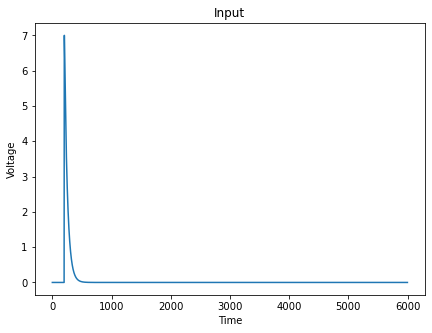

In [8]:
plt.figure(figsize=(7, 5))
plt.plot(data['input'])
plt.xlabel('Time')
plt.ylabel('Voltage')
plt.title('Input')
plt.show()

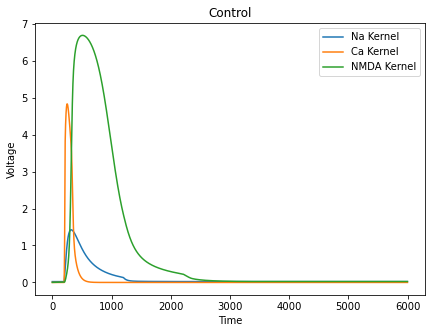

In [9]:
plt.figure(figsize=(7, 5))
plt.plot(data['ca_control'], label='Na Kernel')
plt.plot(data['na_control'], label='Ca Kernel')
plt.plot(data['nmda_control'], label='NMDA Kernel')
plt.xlabel('Time')
plt.ylabel('Voltage')
plt.title('Control')
plt.legend()
plt.show()

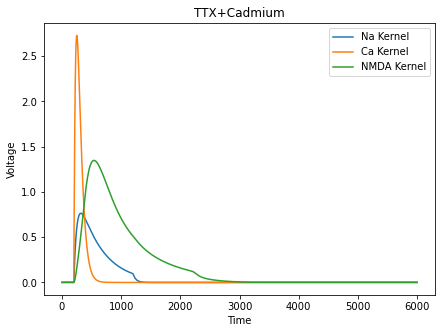

In [10]:
plt.figure(figsize=(7, 5))
plt.plot(data['ca_blocked'], label='Na Kernel')
plt.plot(data['na_blocked'], label='Ca Kernel')
plt.plot(data['nmda_blocked'], label='NMDA Kernel')

plt.xlabel('Time')
plt.ylabel('Voltage')
plt.legend()
plt.title('TTX+Cadmium')
plt.show()

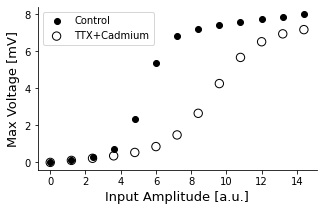

In [11]:
plt.figure(figsize=(5, 3))

ax = plt.subplot(111)
ax.scatter(intensities[::3], peaks_control[::3], marker='o', c='black', label='Control')
ax.scatter(intensities[::3], peaks_blocked[::3], facecolors='none', edgecolors='black', s=70, label='TTX+Cadmium')


# Hide the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# Only show ticks on the left and bottom spines
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')

ax.set_xlabel('Input Amplitude [a.u.]', fontsize=13)
ax.set_ylabel('Max Voltage [mV]', fontsize=13)
ax.legend()

plt.show()